Code Lab 1: Skin Cancer MNIST
=========================

## The Problem

From ISIC 2018: Skin Lesion Analysis Website [https://challenge2018.isic-archive.com]

> Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.

![skin-cancer-cover](imgs/skin-mnist-cover.png "Examples of Skin Lesions")

## Imports

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import pandas as pd
from IPython.display import display, HTML

Let's import Tensorflow now.  It is helpful after importing Tensorflow to check the version of the library installed since the API's are changing so quickly.  Several machines are now starting to use Tensorflow 2.0rc which has a very different interface from v1.* as well.  In preparation for TF 2.0, this tutorial will use the Eager Execution API, which is used by default in future version.

In [3]:
import tensorflow as tf
tf.enable_eager_execution()

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print('Tensorflow version: ',tf.__version__)
print('Is GPU available: %s' % str(tf.test.is_gpu_available()))
print('Is Eager Execution enabled?: %s' % str(tf.executing_eagerly()))

Tensorflow version:  1.13.1
Is GPU available: True
Is Eager Execution enabled?: True


## Dataset

### About HAM10000

In this exercise will will be using  HAM10000 ("Human Against Machine with 10000 training images") dataset which is a collection of "dermatoscopic images from different populations, acquired and stored by different modalities."[Kaggle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000) This dataset has ~10K dermatoscopic images that have been reformatted to be similar smaller like the famous Handwritten Digit or MNIST dataset (64 x 64 images centered on the subject).  This allows us to focus on setting up our environment and making sure we can get a model working on a more interesting, healthcare-related problem.

### Load the dataset

We will load both the included meta file as well as the image data (provided conveniently as a CSV file with one row per image.

In [4]:
IS_ONEPANEL = True
NEED_DOWNLOAD = False
if IS_ONEPANEL:
    DATA_DIR='/onepanel/input/datasets/curae/skin-cancer-mnist/1'
else:
    import os
    import load_data
#     DATA_DIR = '/storage/codelab1'
    DATA_DIR = 'data'
    if NEED_DOWNLOAD:
        if not os.path.exists(DATA_DIR):
            os.mkdir(DATA_DIR)
        FILELIST = ['HAM10000_metadata.csv','train.npz','val.npz']
        load_data.download_files(FILELIST,DATA_DIR)

In [5]:
meta_df = pd.read_csv(os.path.join(DATA_DIR,'HAM10000_metadata.csv'))
train_data = np.load(os.path.join(DATA_DIR,'train.npz'))
test_data = np.load(os.path.join(DATA_DIR,'val.npz'))

### Inspect the meta data

#### Lesions with multiple images

For each image we have a `lesion_id` as well as a an `image_id`.  We should note that there are in fact multiple images for the same lesion which we need to be mindful of as we construct our training and testing splits.  While this has been accounted for in the pre-made splits, it is a potential leakage between the training and validation splits if the same patients were in both populations.

In [6]:
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Below, we count the occurrences of a lesion_id, accumulate the lesions ids with more than 1 image and then add a flag to our original meta_df to indicate whether the lesion has more than one image in the dataset.

In [7]:
def pretty_count_print(series):
    display(pd.DataFrame(series.value_counts()))

In [8]:
lesion_image_counts = pd.DataFrame( meta_df.groupby('lesion_id')['image_id'].count())
dupe_lesion_ids = list(lesion_image_counts[lesion_image_counts['image_id'] > 1].index.values)
meta_df['dupe'] = meta_df.apply(lambda row: row['lesion_id'] in dupe_lesion_ids, axis=1)
pretty_count_print(meta_df['dupe'])

,dupe
False,5514
True,4501


### Classes

The dataset contains 7 classes of lesions, a mixture of both benign and cancerous types.  The dataset is overweight to benign melanocytic nevi, a harmless mole.  However, there are over 2,000 examples of cancerous lesions to detect in this dataset.


| Id |Abbr | Name |
|---|---|---|
| 4 | nv | Melanocytic nevi |
| 6 | mel | Melanoma |
| 2 | bkl | Benign keratosis-like lesion |
| 1 | bcc | Basal cell carcinoma |
| 0 | akiec |  Actinic keratoses |
| 5 | vasc | Vascular lesions (angiomas, etc.) |
| 3 | df | Dermatofibroma |

In [9]:
class_list = ['akiec','bcc','bkl','df','mel','nv','vasc']
pretty_count_print(meta_df['dx'])

,dx
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


Let's gather examples of each class to inspect visually.

In [10]:
example_list = {}
class_names = ['akiec', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']
for cls in range(7):
    example_list[class_names[cls]] = np.nonzero(train_data['labels'] == cls)[0][0]
display(example_list)

{'akiec': 0,
 'df': 301,
 'bkl': 410,
 'vasc': 1434,
 'nv': 1565,
 'bcc': 7519,
 'mel': 8003}

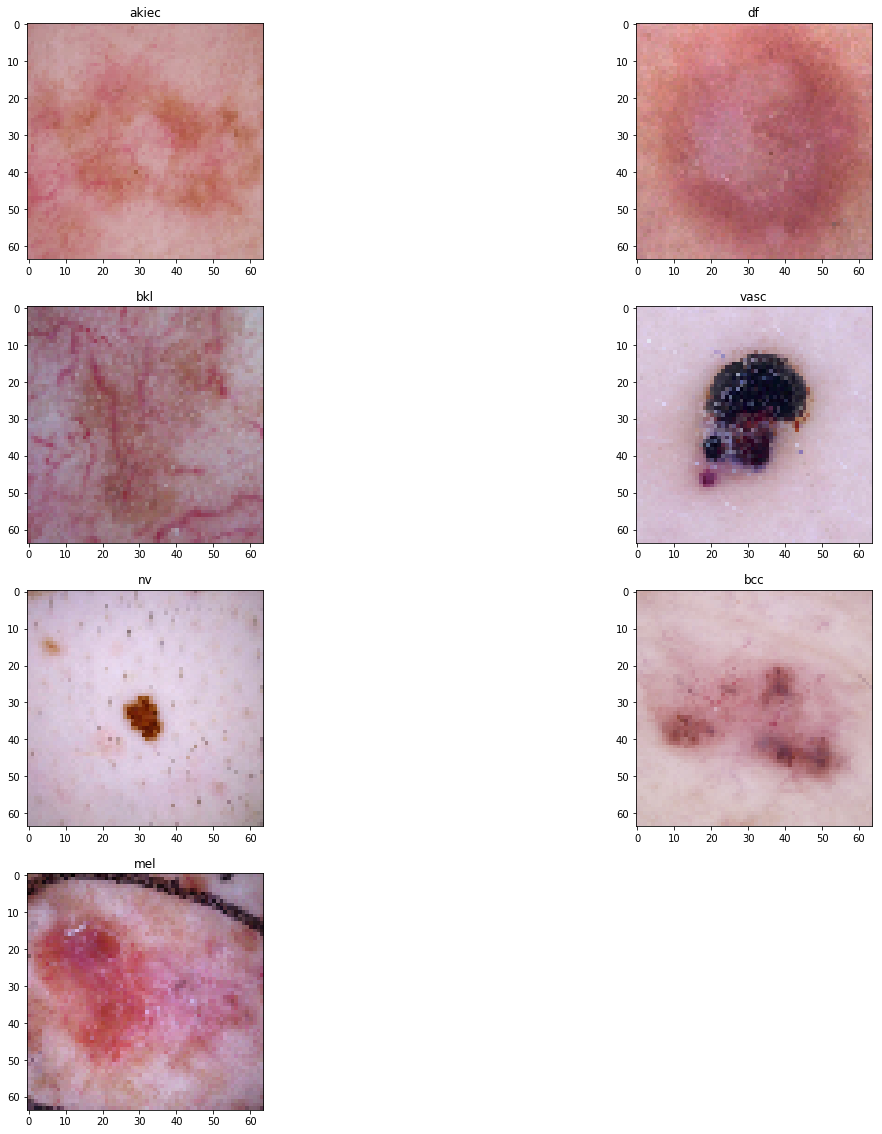

In [11]:
fig, ax = plt.subplots(4,2, figsize=(20,20))
fig.delaxes(ax[3,1]) # Delete the extra plot
for i, (key, value) in enumerate(example_list.items()):
    ax[i//2,i%2].title.set_text(key)
    ax[i//2,i%2].imshow(train_data['images'][value])

### Prepare the data

#### Train/Test Split

A good practice is to divide your data into a training set as well as a testing set.  The neural network parameters are trained using the training dataset.  We hold out a portion of the data into a testing set where we can test the effectiveness of the model in predicting unseen data.  We have already created a 90/10 split for the test set for convenience.

#### Preprocessing

Uniquely with toy datasets like this one, there is not much in the way of preprocessing to accomplish.  We will simply scale the 8-bit color values normalizing the per-channel mean and variance.  It is common practice to only calculate these statistics only on the training population, but use the same normalization parameters for both populations during preprocessing.

In [12]:
channel_mean = np.mean(train_data['images'],axis=(0,1,2))

channel_std = np.std(train_data['images'],axis=(0,1,2))

print("Channel mean: %s" % str(channel_mean))
print("Channel std: %s" % str(channel_std))

train_x = (train_data['images'] - channel_mean) / channel_std
test_x = (test_data['images'] - channel_mean) / channel_std
print("Processed color range: %0.3f to %0.3f" % (np.min(train_x),np.max(train_x)))

Channel mean: [193.70557095 137.91040133 144.01527852]
Channel std: [35.38412952 40.65661319 45.484523  ]
Processed color range: -5.474 to 2.880


**NOTE:** Given the imbalance of the dataset and the low resolution that we are using for demonstration purposes, we will confine ourselves to the binary classification problem of whether a lesion is a "nevus" or "not a nevus".

In [13]:
train_y = np.where(train_data['labels']==4,1,0).reshape(-1,1).astype(np.float32)
test_y = np.where(test_data['labels']==4,1,0).reshape(-1,1).astype(np.float32)

In [14]:
print("Proportion of nevi in train: %0.2f%% vs test: %0.2f%%" 
      % (np.mean(train_y)*100., np.mean(test_y) *100))

Proportion of nevi in train: 65.59% vs test: 80.06%


One last check before proceeding, let's check the data types and sizes of our input data are what we were expecting (9,077 and 938 training and test samples, pictures are 64x64 with 3 color channels, the labels and image data should be floats)

In [15]:
print(train_x.shape, train_x.dtype, train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype, test_y.shape, test_y.dtype)

(9077, 64, 64, 3) float64 (9077, 1) float32
(938, 64, 64, 3) float64 (938, 1) float32


#### Data Loading functions

These functions will load all of the data into the device memory in a format that the Eager Execution API works well when the data provided is via `tf.data.Dataset` which helps create an interable collection of tensors.

These dataloading functions will automatically keep track of shuffling and returning batches of data in the appropriate size.  We can also add an augmentation step to our training dataset loading pipeline by adding a `map` with an augmentation function.

For augmentation, we only apply random flips (both horizontal and vertical).

In [16]:
BATCH_SIZE=64

In [17]:
def augment(images, labels):
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    return images, labels

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset = train_dataset.map(augment).shuffle(2000).batch(BATCH_SIZE)

In [19]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_x,test_y))
test_dataset = test_dataset.batch(BATCH_SIZE)

## Model

Now we will construct the model using the modular Keras API, which will become the preferred method for building models in Tensorflow 2.0.  Specifically we will create a new model class that subclasses `tf.keras.Model` to incorporate our model design.  This helps with organizing the state of our graph as well as helps make models easier to replicate.

In [20]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.activations import sigmoid, softmax

### Design Parameters

There are a number of parameters required when building the model.  Below, we collect the parameters required in the model in the `model_design_params` nested dictionary.  The structure of the dictionary largely follows the design of the VGG-like binary classifier CNN model that we will use to detect whether a lesion is a nevus or not.

In [21]:
model_design_params = {
    # Parameters for blocks
    'blocks' : {
         # Parameters for the 2D convolutional layers
         'conv2d': {
             'kernel_size': 3,
             'strides': 1,
             'padding':'same',
             'activation':'relu',
          },
         # Parameters for the 2D max pooling layers
         'pooling': {
             'pool_size': 2,
             'strides': 2,
          },
         # Dropout hyperparameter for the blocks
         'dropout': 0.25,
     },
     # Parameters for the final head
     'head' : {
         # Use one final affine layer before classifying
         'affine' : {
             'units': 512,
             'activation': 'relu',
         },
         # With dropout
         'dropout': 0.3,
         # Final output settings, note we are not using an activation function, it means we are returning logits
         'logits' : {
             'units': 1,
             'activation': None,
         },   
     }
}

### Model Definition

Our model is going to be of the style of a sequential VGG  model.  These models are composed a t

In [22]:
class VGGStyleBlock(Model):
    def __init__(self, filters, params):
        '''
        :param filters: number of channels in the 2D convolutional layers
        :param params: dictionary of block settings described above
        '''
        super(VGGStyleBlock, self).__init__()
        self.conv1 =  Conv2D(filters, **params['conv2d']) # +2 RF
        self.conv2 =  Conv2D(filters, **params['conv2d']) # +2 RF
        self.maxpool = MaxPooling2D(**params['pooling']) # 2x+1 RF
        self.dropout = Dropout(params['dropout'])
        self.sequential =   Sequential([self.conv1,
                                        self.conv2,
                                        self.maxpool,
                                        self.dropout]) # put it all together
    def call(self, x):
        return self.sequential(x)

In [23]:
class NevusCNNClassifier(Model):
  def __init__(self,params):
    super(NevusCNNClassifier, self).__init__()
    
    # Block 1: 64x64x3 -> 32x32x32
    self.block1 = VGGStyleBlock(filters=32,params=model_design_params['blocks'])
    
    # Block 2: 32x32x32 -> 16x16x64
    self.block2 = VGGStyleBlock(filters=64,params=model_design_params['blocks'])
    
    # Block 3: 16x16x64 -> 8x8x128
    self.block3 = VGGStyleBlock(filters=128,params=model_design_params['blocks'])

    # Features 8x8x128 -> 128 vector representations
    self.gap =      GlobalAveragePooling2D()
    self.features = Sequential([self.block1,
                                self.block2,
                                self.block3,
                                self.gap])
    
    # Head
    self.affine =   Dense(**params['head']['affine'])
    self.head_dropout = Dropout(params['head']['dropout'])
    self.logits =   Dense(**params['head']['logits'])
    self.head =     Sequential([self.affine,
                                self.head_dropout, 
                                self.logits])
    
  def call(self, x):
    x = self.features(x)
    logits = self.head(x)
    probability  = sigmoid(logits)
    return logits, probability

In [24]:
# Create an instance of the model
model = NevusCNNClassifier(model_design_params)

Now that we've constructed the models.  Let's inspect the models now.  Keras comes with two handy built-in features for inspecting models.  Specfically, `model.summary()` and `keras.utils.plot_model`.

In [25]:
tmp = NevusCNNClassifier(model_design_params)
tmp.build((1,64,64,3))
tmp.features.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg_style_block_3 (VGGStyleB multiple                  20288     
_________________________________________________________________
vgg_style_block_4 (VGGStyleB multiple                  110848    
_________________________________________________________________
vgg_style_block_5 (VGGStyleB multiple                  442880    
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
Total params: 287,008
Trainable params: 287,008
Non-trainable params: 0
_________________________________________________________________


In [26]:
tmp.head.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  66048     
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  513       
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________


## Train

No we can finally start to train our model after some final bookkeeping items.

### Training Setup

Now we need to set some key training hyperparameters.

#### Loss Function

We train our model by tuning the parameters of the network until the prediction error or loss converges to a stable value.  Since we are training a binary classifier we will use Sigmoid Cross Entropy or Binary Cross Entropy.  This is closely related to logistic regression.

We will use the Adam optimizer to perform a variation on stochastic gradient descent.  The primary improvement of Adam over normal SGD is that Adam uses adaptive learning rates for its weight updates that depend on the size of the gradients as well as the size of the weights being updated.

In [27]:
global_step = tf.train.get_or_create_global_step()
global_step.assign(1)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [41]:
INITIAL_LEARNING_RATE = 1.e-4
FIRST_DECAY_STEPS = 1000
CLIPVALUE = 1.
EPOCHS = 20

lr_scheduler = tf.train.cosine_decay_restarts(
    INITIAL_LEARNING_RATE,
    global_step,
    FIRST_DECAY_STEPS,
    t_mul=2.0,
    m_mul=1.0,
    alpha=0.0,
)

# optimizer = tf.train.MomentumOptimizerOptimizer(learning_rate=LEARNING_RATE,momentum=0.9)
optimizer = tf.train.AdamOptimizer(learning_rate=lr_scheduler)
loss_function = tf.losses.sigmoid_cross_entropy

#### Performance Metrics

We will track the performance of our model during training using three metrics in addition to tracking our prediction error (loss).  Specifically, we will use 1) binary accuracy, 2) precision and 3) recall.  We will track these metrics in a stateful dictionary for both our training sets and test sets.

In [42]:
train_metrics = {} 
train_metrics['loss'] = tf.keras.metrics.Mean(name='train/loss')
train_metrics['accuracy'] = tf.keras.metrics.BinaryAccuracy(name='train/accuracy')
train_metrics['precision'] = tf.keras.metrics.Precision(name='train/precision')
train_metrics['recall'] = tf.keras.metrics.Recall(name='train/recall')

test_metrics = {} 
test_metrics['loss'] = tf.keras.metrics.Mean(name='test/loss')
test_metrics['accuracy'] = tf.keras.metrics.BinaryAccuracy(name='test/accuracy')
test_metrics['precision'] = tf.keras.metrics.Precision(name='test/precision')
test_metrics['recall'] = tf.keras.metrics.Recall(name='test/recall')

In [43]:
# Helper for printing the metrics
def print_metrics(metric_dict, mode='Train'):
    print(mode,end=' ')
    for key, value in metric_dict.items():
        print(" %s: %0.3f" % (key, value.result()),end='\t')
    print()

In [44]:
# Helper for updating the metrics
def update_metrics(metric_dict,loss, labels, preds):
    metric_dict['loss'].update_state(loss)
    metric_dict['accuracy'].update_state(labels, preds)
    metric_dict['precision'].update_state(labels, preds)
    metric_dict['recall'].update_state(labels, preds)

In [45]:
# Helper for reseting the metrics after each epoch
def reset_metrics(metric_dict):
    for metric_object in metric_dict.values():
        metric_object.reset_states()

#### Training Step

During a training cycle for a single batch of images and labels, we will:
1. Generate a forward pass classification for the training images based on the most current model parameters.
2. During this forward pass, we track which variables in the graph are changing and calculate our error while in the GradientTape context.
3. We then calculate the gradients of the loss with respect to the model's trainable variables.
4. We then use our Adam optimizer to perform a weight update step, hopefully updating a model reduce its training error.

In [46]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits, probability = model(images)
    loss = loss_function(labels, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  update_metrics(train_metrics,loss,labels,probability)
  return probability

Since we are using eager execution, it is easy for us to treat our training cycle like any python function.  Let's run a few steps to make sure everything is working so far.

In [47]:
for image, label in train_dataset.take(10):
    train_step(image,label)
    print_metrics(train_metrics)

Train  loss: 0.482	 accuracy: 0.703	 precision: 0.385	 recall: 0.769	
Train  loss: 0.460	 accuracy: 0.734	 precision: 0.512	 recall: 0.600	
Train  loss: 0.439	 accuracy: 0.766	 precision: 0.600	 recall: 0.545	
Train  loss: 0.418	 accuracy: 0.789	 precision: 0.632	 recall: 0.522	
Train  loss: 0.445	 accuracy: 0.781	 precision: 0.671	 recall: 0.500	
Train  loss: 0.446	 accuracy: 0.781	 precision: 0.685	 recall: 0.521	
Train  loss: 0.437	 accuracy: 0.786	 precision: 0.705	 recall: 0.556	
Train  loss: 0.433	 accuracy: 0.787	 precision: 0.736	 recall: 0.559	
Train  loss: 0.424	 accuracy: 0.795	 precision: 0.745	 recall: 0.591	
Train  loss: 0.428	 accuracy: 0.792	 precision: 0.750	 recall: 0.605	


#### Evaluation Step

To make sure our model training is keeping on track and can still generalize to unseen data, it is useful to calculate the error and performance metrics on a hold out set in an alternating fashion with our training routine.

In [48]:
def test_step(images, labels):
    t_logits, t_probability = model(images)
    t_loss = loss_function(labels, t_logits)
    
    update_metrics(test_metrics,t_loss,labels, t_probability)

We can take a single evaluation step now to make sure that this function and data set are wired correctly as well.

In [49]:
for image, label in test_dataset.take(1):
    test_step(image,label)
    print_metrics(test_metrics)

Train  loss: 0.530	 accuracy: 0.766	 precision: 0.000	 recall: 0.000	


#### Training Loop

Putting this all together, let's run our training step for several cycles until our model's error converges.

Another helpful tool when training a Tensorflow model is to use Tensorboard to a visualize training progress.  Let's create a directory for our Tensorboard outputs and create a writer.

In [53]:
# Update logdir to be a different location to keep track of old runs
logdir = "/onepanel/output/model2"
writer = tf.contrib.summary.create_file_writer(logdir)
writer.set_as_default()

Another helpful practice is to persist checkpoints of our model every so often.  Tensorflow allows us to save the current model weights, optimizer values as well as the current step.

In [54]:
checkpoint_dir = logdir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model,
                           optimizer_step=tf.train.get_or_create_global_step())

root.save(checkpoint_prefix)

'/onepanel/output/model2/ckpt-1'

Now for the fun part, we push 'RUN' and wait!

In [55]:
for epoch in range(EPOCHS):
    for images, labels in train_dataset:
        global_step.assign_add(1)

        with tf.contrib.summary.record_summaries_every_n_global_steps(100):
            preds = train_step(images, labels)
            for metric, val in train_metrics.items():
                tf.contrib.summary.scalar('train/'+ metric, val.result())
                tf.contrib.summary.histogram('train/predictions',preds)
            tf.contrib.summary.scalar('learning_rate', lr_scheduler())

    
    for test_images, test_labels in test_dataset:
        test_step(test_images, test_labels)
    with tf.contrib.summary.always_record_summaries():
        for metric, val in test_metrics.items():
            tf.contrib.summary.scalar('test/'+ metric, val.result())

    print("Epoch {} ==================".format(epoch))
    print_metrics(train_metrics)
    print_metrics(test_metrics, "Test")
    # Reset the metrics for the next epoch
    reset_metrics(train_metrics)
    reset_metrics(test_metrics)

Epoch 0 ==================
Train  loss: 0.371	 accuracy: 0.830	 precision: 0.873	 recall: 0.864	
Test  loss: 0.323	 accuracy: 0.837	 precision: 0.915	 recall: 0.863	
Epoch 1 ==================
Train  loss: 0.368	 accuracy: 0.830	 precision: 0.879	 recall: 0.859	
Test  loss: 0.309	 accuracy: 0.840	 precision: 0.947	 recall: 0.848	
Epoch 2 ==================
Train  loss: 0.357	 accuracy: 0.834	 precision: 0.877	 recall: 0.868	
Test  loss: 0.304	 accuracy: 0.854	 precision: 0.955	 recall: 0.858	
Epoch 3 ==================
Train  loss: 0.358	 accuracy: 0.836	 precision: 0.881	 recall: 0.867	
Test  loss: 0.300	 accuracy: 0.854	 precision: 0.953	 recall: 0.860	
Epoch 4 ==================
Train  loss: 0.367	 accuracy: 0.829	 precision: 0.872	 recall: 0.867	
Test  loss: 0.306	 accuracy: 0.861	 precision: 0.956	 recall: 0.867	
Epoch 5 ==================
Train  loss: 0.396	 accuracy: 0.813	 precision: 0.836	 recall: 0.889	
Test  loss: 0.289	 accuracy: 0.877	 precision: 0.952	 recall: 0.892	
Epoc

### Tensorboard

Since we have included calls to our `tf.summary.Writer` that we set up for `model1` log directory, we can watch our model training with finer grained statistics in TensorBoard.  We will now demo getting into the Tensorboard interface now.

Hopefully, we see our losses for both our training set and our held-out test set declining to convergence.  Also, we should see our accuracy, precision and recall climb to a stable number during training.  However, in using a learning rate rescheduler with restarts, the metrics can get a little bumpy around the times when the learning rate jumpbs back up.

If we start to see our training performance parameters greatly outpacing our training performance, then we may be overfitting to the training data, and our model may not generalize well to unseen skin lesions in the future.

## Evaluation

### Score the Model

In [58]:
_ , test_preds = model(test_x)

In [78]:
THRESHOLD = 0.4
test_class = np.where(test_preds.numpy() > THRESHOLD, 1, 0)

In [79]:
import sklearn
display(sklearn.metrics.classification_report(test_y,test_class, output_dict=True))

{'0.0': {'precision': 0.7868852459016393,
  'recall': 0.7700534759358288,
  'f1-score': 0.7783783783783783,
  'support': 187},
 '1.0': {'precision': 0.9430463576158941,
  'recall': 0.948069241011984,
  'f1-score': 0.9455511288180611,
  'support': 751},
 'micro avg': {'precision': 0.9125799573560768,
  'recall': 0.9125799573560768,
  'f1-score': 0.9125799573560768,
  'support': 938},
 'macro avg': {'precision': 0.8649658017587667,
  'recall': 0.8590613584739064,
  'f1-score': 0.8619647535982198,
  'support': 938},
 'weighted avg': {'precision': 0.9119140251099606,
  'recall': 0.9125799573560768,
  'f1-score': 0.9122235122591904,
  'support': 938}}

In [87]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function 
    s and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    FROM: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[sklearn.utils.multiclass.unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


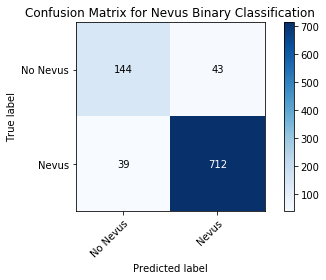

In [88]:
plot_confusion_matrix(test_y,test_class,['No Nevus','Nevus'],title='Confusion Matrix for Nevus Binary Classification')

### Inspect Predictions

In [116]:
wrong_mask = (test_y != test_class).reshape(-1)
wrong_labels = test_data['labels'][wrong_mask]
wrong_preds = test_class[wrong_mask]
wrong_images = test_x[wrong_mask]

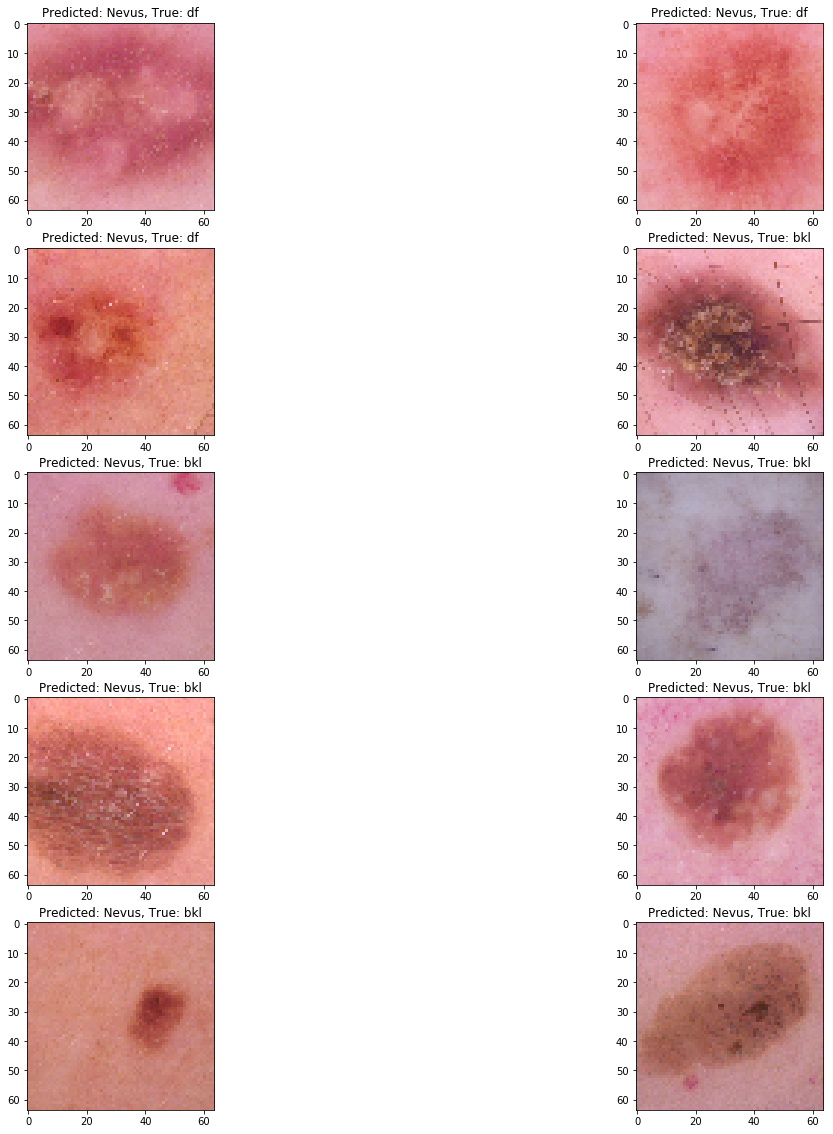

In [119]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
for i, (label, pred, image_std) in enumerate(zip(wrong_labels[:10],wrong_preds[:10],wrong_images[:10])):
    label_txt = class_names[label]
    pred_txt = 'No Nevus' if pred == 0 else 'Nevus'
    original_image = (image_std * channel_std +  channel_mean).astype(np.uint8)
    ax[i//2,i%2].title.set_text('Predicted: %s, True: %s' % (pred_txt, label_txt))
    ax[i//2,i%2].imshow(original_image)

### Inspect feature vector

In [89]:
test_features = model.features(test_x)

In [90]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
test_features_2d = pca.fit(test_features).transform(test_features)

In [99]:
nevus_mask, no_nevus_mask = (test_y == 1).reshape(-1), (test_y == 0).reshape(-1)

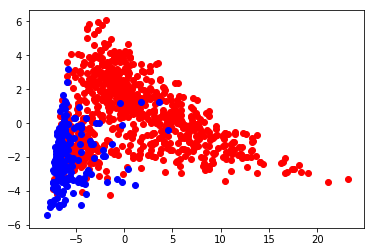

In [102]:
plt.scatter(test_features_2d[nevus_mask,0],test_features_2d[nevus_mask,1],color='r')
plt.scatter(test_features_2d[no_nevus_mask,0],test_features_2d[no_nevus_mask,1], color='b')